# Train a BNN to classify MNIST using neural SVGD

In [1]:
# Train a Bayesian neural network to classify MNIST using
# Neural SVGD
#
# If using pmap, set the environment variable
# `export XLA_FLAGS="--xla_force_host_platform_device_count=8"`
# before running on CPU (this enables pmap to "see" multiple cores).
%load_ext autoreload
import sys
sys.path.append("../../experiments/")
from functools import partial
from itertools import cycle

import numpy as onp
import jax
from jax import numpy as jnp
from jax import jit, grad, value_and_grad, vmap, pmap, config, random
config.update("jax_debug_nans", False)
from jax.ops import index_update, index
import matplotlib.pyplot as plt
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.calibration import calibration_curve
import tensorflow_datasets as tfds

import haiku as hk
import optax

import nets
import utils
import models
import metrics
from convnet import make_model, accuracy, crossentropy_loss, log_prior, ensemble_accuracy

import os
on_cluster = not os.getenv("HOME") == "/home/lauro"
model = make_model("small")

# Config
key = random.PRNGKey(0)
EPOCHS = 1
# NUM_VALS = 20

META_LEARNING_RATE = 5e-4

NUM_SAMPLES = 150
DISABLE_PROGRESS_BAR = False
USE_PMAP = False

BATCH_SIZE = 128
LAMBDA_REG = 10**2
STEP_SIZE = 1e-4 #1e-3, 1e-4 too large (w adam)
PATIENCE = 5
MAX_TRAIN_STEPS = 100 #15


if USE_PMAP:
    vpmap = pmap
else:
    vpmap = vmap

# Load MNIST
data_dir = './data' if on_cluster else '/tmp/tfds'
mnist_data, info = tfds.load(name="mnist", batch_size=-1, data_dir=data_dir, with_info=True)
mnist_data = tfds.as_numpy(mnist_data)
train_data, test_data = mnist_data['train'], mnist_data['test']

# Full train and test set
train_images, train_labels = train_data['image'], train_data['label']
test_images, test_labels = test_data['image'], test_data['label']

# Split off the validation set
train_images, val_images, train_labels, val_labels = train_test_split(
    train_images, train_labels, test_size=0.1, random_state=0)
data_size = len(train_images)


def make_batches(images, labels, batch_size):
    """Returns an iterator that cycles through 
    tuples (image_batch, label_batch)."""
    num_batches = len(images) // batch_size
    split_idx = onp.arange(1, num_batches+1)*batch_size
    batches = zip(*[onp.split(data, split_idx, axis=0) for data in (images, labels)])
    return cycle(batches)


def loss(params, images, labels):
    """Minibatch approximation of the (unnormalized) Bayesian
    negative log-posterior evaluated at `params`. That is,
    -log model_likelihood(data_batch | params) * batch_rescaling_constant - log prior(params))"""
    logits = model.apply(params, images)
    return data_size/BATCH_SIZE * crossentropy_loss(logits, labels) - log_prior(params)

In [2]:
%autoreload

# Neural SVGD Model
* Input: model parameters
* Output: 'gradient' of same shape as parameters

### Memory
Assume: convnet model has 50.000 parameters, and NSVGD layers have hidden dimensions `[1024, 1024]`. Then the NSVGD (meta) model has `2*50.000*1024` parameters (each 8 bytes), i.e. about 800MB.

The activations: `50.000 + 1024 + 1024 + 50.000` floats, i.e. about 800KB, times `NUM_SAMPLES`.

In [3]:
# Utility functions for dealing with parameters
key, subkey = random.split(key)
params_tree = model.init(subkey, train_images[:2])
params_flat, unravel = jax.flatten_util.ravel_pytree(params_tree)


def ravel(tree):
    return jax.flatten_util.ravel_pytree(tree)[0]


def init_flat_params(key):
    return ravel(model.init(key, train_images[:2]))


def get_minibatch_logp(batch):
    """
    args:
        batch = (images, labels)

    Returns a callable that computes target posterior
    given flattened param vector.
    """
    def minibatch_logp(params_flat):
        return -loss(unravel(params_flat), *batch)
    return minibatch_logp


def sample_tv(key):
    """return two sets of particles at initialization, for
    training and validation in the warmup phase"""
    return vmap(init_flat_params)(random.split(key, NUM_SAMPLES)).split(2)


@jit
def acc(param_set_flat):
    param_set = vmap(unravel)(param_set_flat)
    logits = vmap(model.apply, (0, None))(param_set, val_images[:BATCH_SIZE])
    return ensemble_accuracy(logits, val_labels[:BATCH_SIZE])


def vmean(fun):
    """vmap, but computes mean along mapped axis"""
    def compute_mean(*args, **kwargs):
        return jnp.mean(vmap(fun)(*args, **kwargs), axis=-1)
    return compute_mean

In [4]:
train_batches = make_batches(train_images, train_labels, BATCH_SIZE)
test_batches  = make_batches(test_images,  test_labels, BATCH_SIZE)

# init particles and dynamics model

In [5]:
%autoreload

In [6]:
key, subkey = random.split(key)
init_particles = vmap(init_flat_params)(random.split(subkey, NUM_SAMPLES))

opt = optax.sgd(STEP_SIZE)

# opt = optax.chain(
#     optax.scale_by_adam(),
#     optax.scale(-STEP_SIZE),
# )

key, subkey1, subkey2 = random.split(key, 3)
neural_grad = models.SDLearner(target_dim=init_particles.shape[1],
                               get_target_logp=get_minibatch_logp,
                               learning_rate=META_LEARNING_RATE,
                               key=subkey1,
                               sizes=[256, 256, 128, init_particles.shape[1]],
                               aux=False,
                               use_hutchinson=True,
                               lambda_reg=LAMBDA_REG,
                               patience=PATIENCE,
                               dropout=True)
particles = models.Particles(subkey2, neural_grad.gradient, init_particles, custom_optimizer=opt)

In [7]:
# maximal initial stein discrepancy (theoretical ideal)
import plot
import stein
from jax.scipy import stats

n, d = init_particles.shape
n = 100
key, subkey = random.split(key)
xs = random.normal(subkey, (n, d)) / 100

first_batch = next(train_batches)
images, labels = first_batch

def logp(x):
    def loglikelihood(x):
        params = unravel(x)
        logits = model.apply(params, images)
        return -data_size/BATCH_SIZE * crossentropy_loss(logits, labels)
    return loglikelihood(x) + log_prior(unravel(x))


def logq(x):
    return stats.norm.logpdf(x, loc=0, scale=1/100).sum()


def f(x):
    def loglikelihood(x):
        params = unravel(x)
        logits = model.apply(params, images)
        return -data_size/BATCH_SIZE * crossentropy_loss(logits, labels) / (2*LAMBDA_REG)
    return grad(loglikelihood)(x)

# double-check stein discrepancy

# a) true
l2 = utils.l2_norm_squared(xs, f) # = sd(f*) / (2 LAMBDA_REG)
true_sd = 2 * LAMBDA_REG * l2
min_loss = -l2 * LAMBDA_REG

# b) hutchinson
key, subkey = random.split(key)
random_estimate_sd = stein.stein_discrepancy_hutchinson(subkey, xs, logp, f)

print("analytical sd:", true_sd)
print("hutchinson estimate:", random_estimate_sd)
print("ratio:", true_sd / random_estimate_sd)

analytical sd: 123019.32
hutchinson estimate: 122815.88
ratio: 1.0016564


# train

In [8]:
# Warmup on first batch
NUM_WARMUP_ITER = 5
key, subkey = random.split(key)
neural_grad.warmup(key=subkey,
                   sample_split_particles=sample_tv,
                   next_data=lambda: first_batch,
                   n_iter=NUM_WARMUP_ITER,
                   n_inner_steps=100,
                   progress_bar=True)

100%|██████████| 5/5 [00:16<00:00,  3.32s/it]


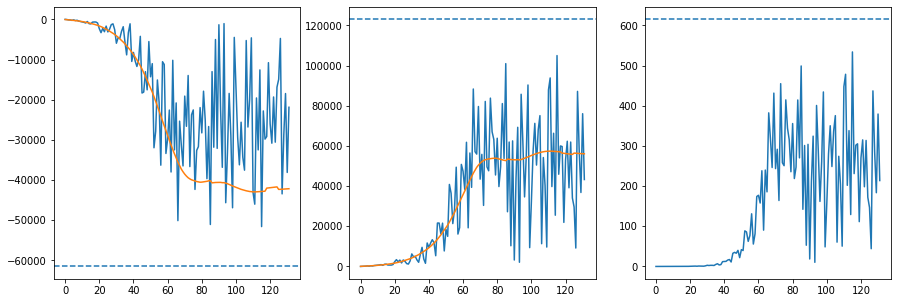

In [9]:
fig, axs = plt.subplots(1, 3, figsize=[15, 5])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'])
ax.plot(neural_grad.rundata['validation_loss'])
ax.axhline(y=min_loss, label="true first-batch loss", linestyle="--")

ax = axs[1]
ax.plot(neural_grad.rundata['training_sd'])
ax.plot(neural_grad.rundata['validation_sd'])
ax.axhline(y=true_sd, linestyle="--", label="true first-batch stein discrepancy")

ax = axs[2]
ax.plot(neural_grad.rundata['l2_norm'])
ax.axhline(y=l2, linestyle="--", label="true l2 norm")

In [10]:
key, fixed_key = random.split(key)
def step(key, train_batch):
    """one iteration of the particle trajectory simulation"""
    neural_grad.train(
        split_particles=particles.next_batch(fixed_key), # TODO this is a test, fixed train/val splits
        n_steps=MAX_TRAIN_STEPS,
        data=train_batch
    )
    particles.step(neural_grad.get_params())


@jit
def compute_eval(train_batch, ps):
    test_logp = vmean(get_minibatch_logp(next(test_batches)))
    train_logp = vmean(get_minibatch_logp(train_batch))
    stepdata = {
        "accuracy": acc(ps),
        "test_logp": test_logp(ps),
        "training_logp": train_logp(ps),
        "particle_mean": ps.mean(),
    }
    return stepdata

# changelog:
### 20.01
* fixed calculation of hutchinson estimator; now stein discrepancies make sense and training is more stable.

### 21.01
* decreased particle step size by 1/5 *plus again 1/10*
* increased warmup period by 100 steps.
    * now we won't have initial chill training period
* decreasing *by 1/10 again* helped! Now first 12 steps run without error.

### 22.01
* changed training procedure (reshuffle train/val particles only on new batch)
    * training is stable for longer now
    * still overfits and diverges after some time though
    * accuracy stays constant
* made base convnet larger, in the hopes of better early training
    * didn't work, net is smol again
* realized problem is a few (2-3) particles diverging off to infty
    * possible solution: cap gradients
    * gradient norm is usually (langevin) around global_norm=0.1, *after* step size applied!
    * didn't really work
* I think basic issue is still that the meta network learns the wrong gradient.
    * (worth a try) run again w/ more particles, maybe that reduces overfitting
    * also: DONE set train/val split to 50/50, see if weird divergence in loss still there
    * cause: HYPOTHESIS: the reason train/val loss is strange right now (ie diverging and not really reshuffling as it should) is b/c of the only asymmetry: most particles are in the train set, so outliers also more likely to land there.
        * Minor other point is that maybe 50/50 split stabilizes training (cause it reduces possibility for overfitting)
        * EVIDENCE FOR HYPOTHESIS: it is indeed the case that, for this 50/50 split run, the loss fn behaviour makes perfect sense (overfitting on train set but not val, and reset after reshuffle, gradually overfitting on the whole set)
* next HYPOTHESIS: The network learns the wrong thing. If the network learns a wrong thing, that's cause of overfitting. And if it overfits, that's cause it trains too long.
    * next DONE: reduce max nr of steps. (now 15)
        * still too much. Now: reduce patience to 1 and nr steps to 5
    * next DONE: check bayesian logistic regression (covertype) to see how I handled patience / num steps there.
        * I used the default `patience=0` and maximum 10 training steps.
    
### 23.01
* DONE: check if the problem is that I'm normalizing the inputs
* A) RESULTS: reduced to 5 steps and `patience=0`, but particles are still getting away (despite clipping).
* B) NEW RESULTS: *particles no longer getting away*, ie individual particles no longer leaving the group. BUT: loss still diverges, so def overfitting.
    * I *think* the difference between A and B is that for B, I used larger network size: `[128, 128, 128]` rather than `[64, 64]`. But we'll know soon.
    * Update: that wasn't it. So then it's the train/test split? I used to do 3:1, now 1:1.
    * Ah, part of it is ADAM optimizer: def rougher without ADAM.
    * Now it's unclear which one is more impactful for avoiding particle escape:
        * better train/test split
        * ADAM optimizer
    * I do know that gradient clipping alone doesn't solve escape (makes it slower tho), and neither do (slightly) larger models.
    * TODO things I will soon add:
        * dropout
        * weight decay
    * need to eval these systematically, or it'll be a total clusterfuck
* SITUATION: particle escape seems solved, but:
    * meta loss goes to -infty exponentially (must be either an error, or terrible overfitting)
    * particle loss goes to infty exponentially (how tf does that work)
    * particle trajectories behave weirdly, but not obviously degenerate (eg no more particle escape)
* TODO:
    * compare particle gradient norms (pre and post processing) to langevin gradients. Should be roughly same scale; if not, rescale STEP_SIZE.
    * look at (meta-) NN gradients. Should be reasonable; if not, adjust learning rate.
    
### 24.01
* New metrics:
    * particle gradient norms
    * update model gradient norms
* New comparison
    * compare loss to maximum loss at the beginning, so to confirm that we're overfitting.
* **Summary on particle escape**
    * Problem: individual particles diverge (while the rest stay on track or barely move); this leads to heavy overfitting on RSD loss
    * Gradient clipping does not help
    * In theory, a better training / validation split should help; shuffling often and using many particles means less likely to overfit on any single (set of) particles; *not* confirmed by experiment.
    * In practice, just using adam instead of gradient clipping seems to work well.
* Larger models
    * larger models take similar time to train; more expensive per step, but they early stop themselves muuch faster (ie cause they converge faster)
* **Summary on overfitting**
    * Problem: after a short initial period, the RSD loss decreases as -exp(c * t) without any sign of slowing down.
    * HYPOTHESIS: this is due to the large feedforward network; a [32, 32] network will overfit less.
        * DISCONFIRMED: a [32, 32] network overfits just fine. This begs the question of why it doesn't do so in other experiments!

#### main problem solved
* it was a sign error... ofc, this changes everything

### 25.01
* accuracy is v similar to langevin; converges to slightly lower point.

### future

In [11]:
# now use SGD with larger LR 1e-3

* currently testing what happens if we **fix** train/val splits
    * outcome: no overfit!

In [12]:
# num_steps = EPOCHS * data_size // BATCH_SIZE // 5
num_steps = 201
for step_counter in tqdm(range(num_steps)):
    key, subkey = random.split(key)
    train_batch = next(train_batches)
    step(subkey, train_batch)
#     if step_counter % (num_steps//NUM_VALS) == 0:
    if step_counter % 10 == 0:
        metrics.append_to_log(particles.rundata,
                              compute_eval(train_batch, particles.particles))
# neural_grad.done()
# particles.done()

100%|██████████| 201/201 [06:25<00:00,  1.92s/it]


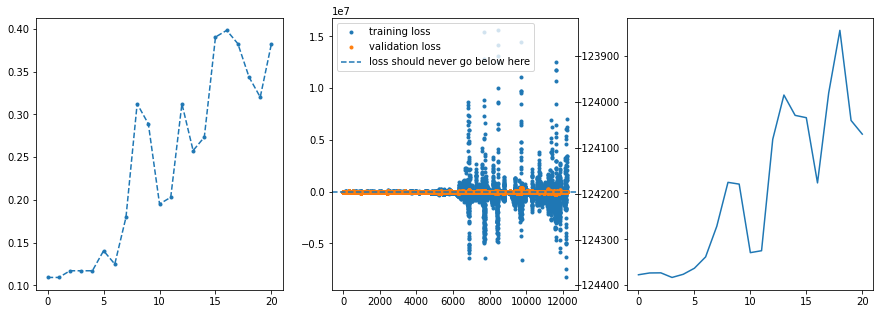

In [13]:
fig, axs = plt.subplots(1, 3, figsize=[15, 5])

ax = axs[0]
ax.plot(particles.rundata["accuracy"], "--.")

ax = axs[1]
ax.plot(neural_grad.rundata['training_loss'], ".", label="training loss")
ax.plot(neural_grad.rundata['validation_loss'], ".", label="validation loss")
ax.axhline(y=min_loss, label="loss should never go below here", linestyle="--")
ax.legend()

ax = axs[2]
ax.plot(particles.rundata['training_logp'])
# ax.plot(particles.rundata['test_logp'])

In [14]:
particles.rundata['accuracy'][-10:]

[DeviceArray(0.203125, dtype=float32),
 DeviceArray(0.3125, dtype=float32),
 DeviceArray(0.2578125, dtype=float32),
 DeviceArray(0.2734375, dtype=float32),
 DeviceArray(0.390625, dtype=float32),
 DeviceArray(0.3984375, dtype=float32),
 DeviceArray(0.3828125, dtype=float32),
 DeviceArray(0.34375, dtype=float32),
 DeviceArray(0.3203125, dtype=float32),
 DeviceArray(0.3828125, dtype=float32)]

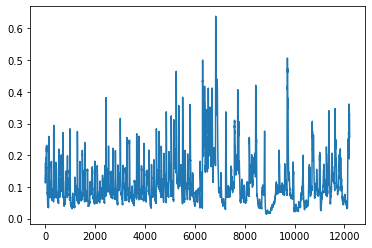

In [15]:
plt.plot(neural_grad.rundata["global_gradient_norm"])

In [16]:
trajectories = onp.array(particles.rundata['particles'])
trajectories.shape

(201, 150, 70)

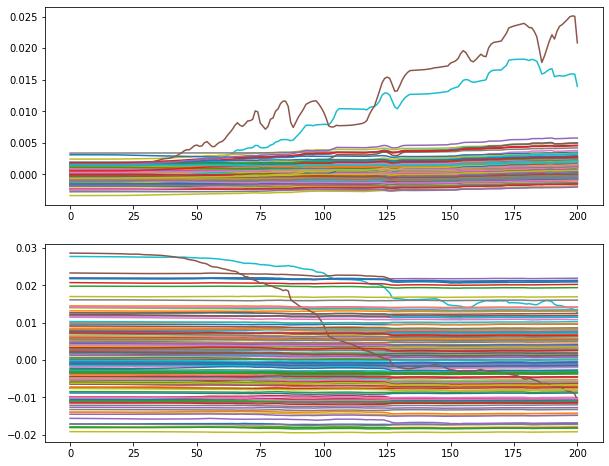

In [17]:
# visualize trajectory avg across dimensions (distinguish particles)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=2));  # avg across dims

ax = axs[1]
ax.plot(trajectories[:, :, 1]);  # watch single param (aka single dimension)

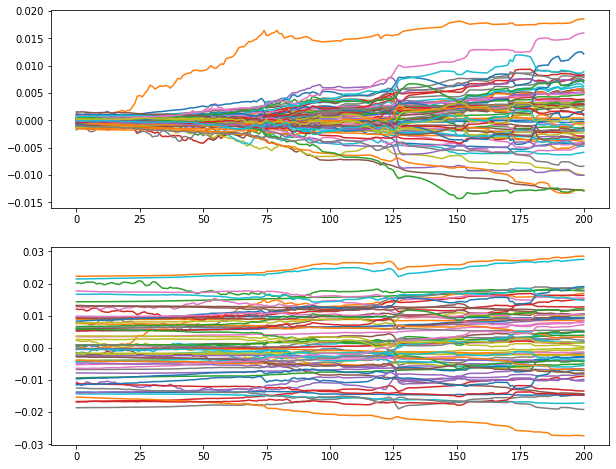

In [18]:
# visualize trajectory avg across particles (distinguish dims, ie parameters)
fig, axs = plt.subplots(2, 1, figsize=[10, 8])

ax = axs[0]
ax.plot(trajectories.mean(axis=1)); # avg across particles

ax = axs[1]
ax.plot(trajectories[:, 11, :]); # watch single particle

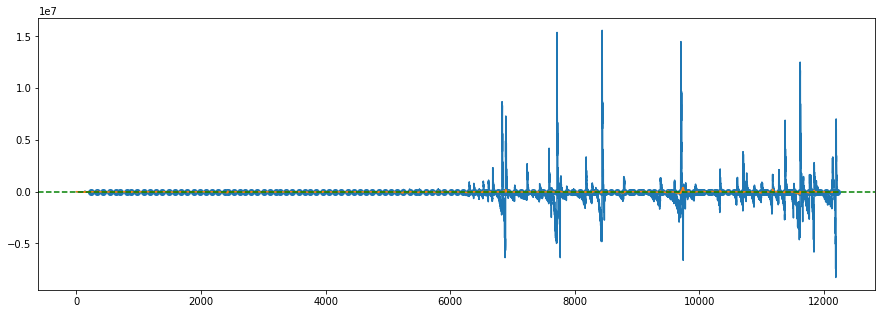

In [19]:
# generate markings based on num_steps
plt.subplots(figsize=[15, 5])
markings = onp.cumsum(neural_grad.rundata['train_steps'])[NUM_WARMUP_ITER:]

plt.plot(neural_grad.rundata['training_loss'])
plt.plot(neural_grad.rundata['validation_loss'])
plt.scatter(markings, onp.zeros(len(markings)))
plt.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")

step 6 to step 9.


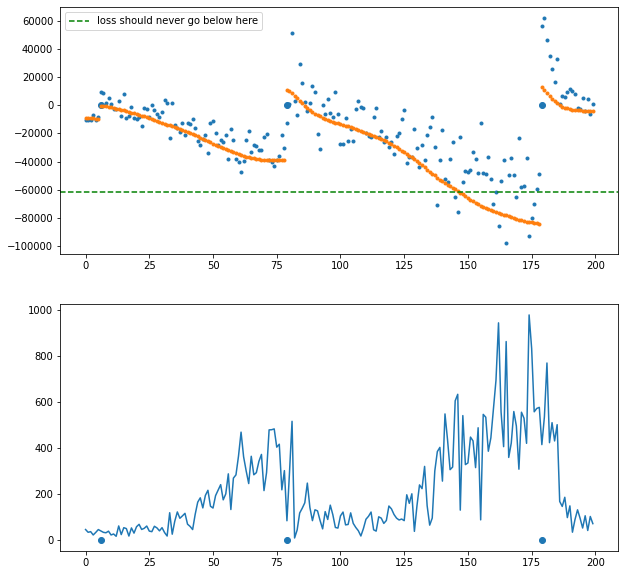

In [20]:
a = 800
b = 1000
marker_a = (markings < a).sum()
marker_b = (markings < b).sum()
print(f"step {marker_a} to step {marker_b}.")

fig, axs = plt.subplots(2, figsize=[10, 10])

ax = axs[0]
ax.plot(neural_grad.rundata['training_loss'][a:b], ".")
ax.plot(neural_grad.rundata['validation_loss'][a:b], ".")
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
ax.axhline(y=min_loss, label="loss should never go below here", linestyle="--", color="g")
ax.legend()
# ax.set_yscale('log')

ax = axs[1]
ax.plot(neural_grad.rundata['l2_norm'][a:b])
ax.scatter(markings[marker_a:marker_b] - a, onp.zeros(marker_b - marker_a))
# ax.set_yscale('log')

# particle gradient norms

In [21]:
gs = neural_grad.grads(particles.particles)
optax.global_norm(gs)

DeviceArray(506.71655, dtype=float32)

In [22]:
print("norm pre upate :", particles.rundata['global_grad_norm'][0])
print("norm post upate:", particles.rundata['global_grad_norm_post_update'][0])

norm pre upate : 109.428696
norm post upate: 0.010942872


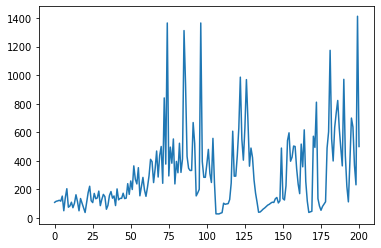

In [23]:
plt.plot(particles.rundata['global_grad_norm'])

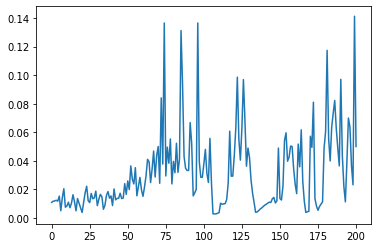

In [24]:
plt.plot(particles.rundata['global_grad_norm_post_update'])

In [25]:
optax.global_norm(vmap(unravel)(particles.particles))

DeviceArray(1.6450341, dtype=float32)

In [26]:
jnp.sqrt(jnp.sum(particles.particles**2))

DeviceArray(1.6450341, dtype=float32)

# model gradient norms

### interlude: why accuracy no change?

In [27]:
all_preds = vmap(lambda ps: model.apply(unravel(ps), val_images[:128]).argmax(axis=1))(particles.rundata['particles'][-1])
onp.unique(all_preds, return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=int32),
 array([2585, 6796, 1280, 1902, 1950,   81, 1629, 2531,  138,  308]))

### continue with scheduled programming